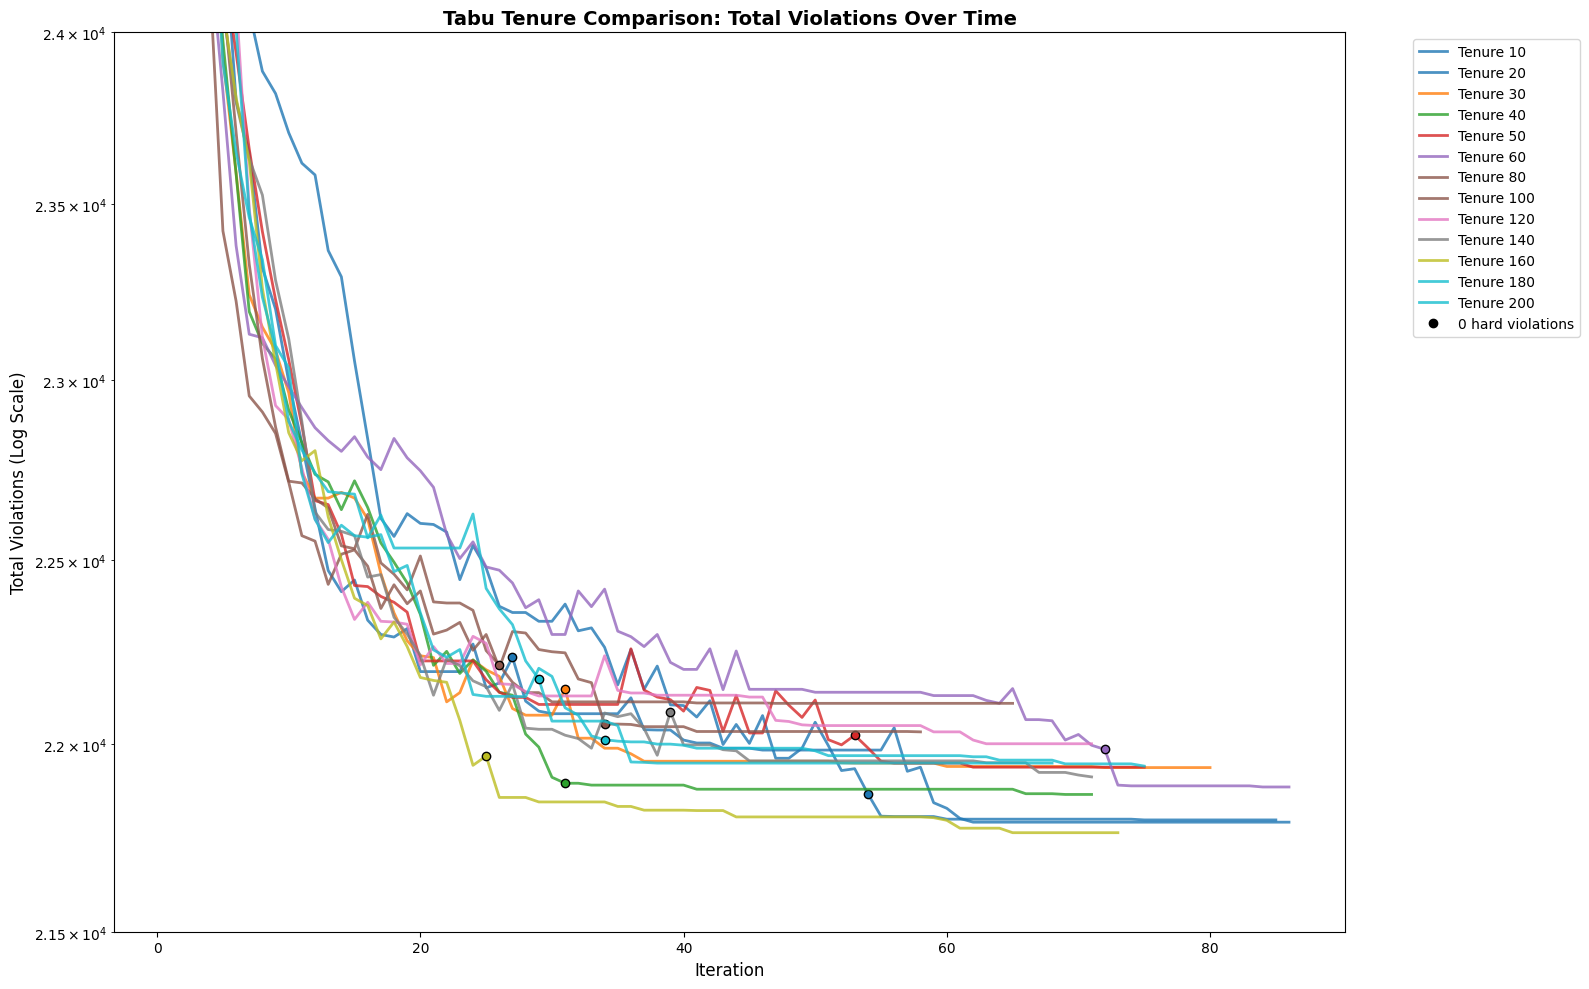

In [41]:
import matplotlib.pyplot as plt
import re
import numpy as np
import os
from pathlib import Path

def parse_tenure_log(log_text):
    """Parse a single log file to extract iteration and violation data."""
    lines = log_text.strip().split('\n')
    
    iterations = []
    total_violations = []
    hard_violations = []
    reheating_iterations = []
    ruin_iterations = []
    
    current_iteration = None
    
    for line in lines:
        # Match iteration lines with violations
        iteration_match = re.search(r'Iteration: (\d+),.*\(Hard: (\d+), Medium: (\d+), Soft: (\d+)\)', line)
        if iteration_match:
            iteration = int(iteration_match.group(1))
            hard = int(iteration_match.group(2))
            medium = int(iteration_match.group(3))
            soft = int(iteration_match.group(4))
            total = hard + medium + soft
            
            iterations.append(iteration)
            total_violations.append(total)
            hard_violations.append(hard)
            current_iteration = iteration
        
        # Detect reheating
        if "Reheating" in line and current_iteration is not None:
            reheating_iterations.append(current_iteration)
        
        # Detect ruin and recreate
        if "Ruin and Recreate successful" in line and current_iteration is not None:
            ruin_iterations.append(current_iteration)
    
    return {
        'iterations': iterations,
        'total_violations': total_violations,
        'hard_violations': hard_violations,
        'reheating_iterations': reheating_iterations,
        'ruin_iterations': ruin_iterations
    }

def read_all_tenure_results(base_dir):
    """Read all tenure test results from the directory structure."""
    base_path = Path(base_dir)
    tenure_results = {}
    
    if not base_path.exists():
        print(f"Directory {base_path} does not exist!")
        return tenure_results
    
    tenure_dirs = [d for d in base_path.iterdir() if d.is_dir() and d.name.startswith('tenure_')]
    
    for tenure_dir in sorted(tenure_dirs):
        tenure_value = int(tenure_dir.name.split('_')[1])
        log_files = list(tenure_dir.glob('run_*.log'))
        
        if log_files:
            log_file = log_files[0]  # Use first run
            try:
                with open(log_file, 'r') as f:
                    log_text = f.read()
                data = parse_tenure_log(log_text)
                if data['iterations']:
                    tenure_results[tenure_value] = data
            except:
                pass
    
    return tenure_results

def plot_tenure_comparison(base_dir):
    """Plot total violations for all tenure values on the same graph."""
    tenure_results = read_all_tenure_results(base_dir)
    
    if not tenure_results:
        print("No tenure results found!")
        return
    
    plt.figure(figsize=(16, 10))
    colors = plt.cm.tab10(np.linspace(0,1, len(tenure_results)))
    
    for i, (tenure_value, data) in enumerate(sorted(tenure_results.items())):
        color = colors[i]
        
        # Plot total violations
        plt.plot(data['iterations'], data['total_violations'], 
                color=color, linewidth=2, label=f'Tenure {tenure_value}', alpha=0.8)
        
        # Find when hard violations first reach 0
        zero_hard_iteration = None
        for j, hard_count in enumerate(data['hard_violations']):
            if hard_count == 0:
                zero_hard_iteration = data['iterations'][j]
                break
        
        # Highlight when hard violations reach 0
        if zero_hard_iteration is not None:
            idx = data['iterations'].index(zero_hard_iteration)
            plt.plot(zero_hard_iteration, data['total_violations'][idx], 
                    marker='.', color=color, markersize=12, 
                    markeredgecolor='black', markeredgewidth=1)
                    
        plt.ylim(2.15*10**4, 2.4*10**4)  # Set y-axis limit
        #plt.xlim(0, max(data['iterations']))  # Set x-axis limit
    
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Total Violations (Log Scale)', fontsize=12)
    plt.title('Tabu Tenure Comparison: Total Violations Over Time', fontsize=14, fontweight='bold')
    
    # Create custom legend elements
    from matplotlib.lines import Line2D
    
    # Get the current legend handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Add custom legend entry for the dots
    dot_legend = Line2D([0], [0], marker='.', color='black', linestyle='None', 
                       markersize=12, markeredgecolor='black', markeredgewidth=1,
                       label='. 0 hard violations')
    
    # Combine all legend elements
    all_handles = handles + [dot_legend]
    all_labels = labels + ['0 hard violations']
    
    plt.legend(handles=all_handles, labels=all_labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

# Use the correct path from src/util/ (go up two levels to root)
plot_tenure_comparison("../../../benchmark_tests/tabu_tenure_test/")